# ANN For Churn Prediction

Given a Bank customer, can we build a classifier which can determine whether they will leave or not using Neural networks?

## Imports

In [1]:
#Importing libraries
import numpy as np  # linear algebra
import pandas as pd  # data processing
import os
import matplotlib.pyplot as plt  #visualization
from PIL import Image
%matplotlib inline
import pandas as pd
import seaborn as sns  #visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py  #visualization
py.init_notebook_mode(connected=True)  #visualization
import plotly.graph_objs as go  #visualization
import plotly.tools as tls  #visualization
import plotly.figure_factory as ff  #visualization

from sklearn.model_selection import train_test_split

# Data Exploration

In [2]:
df=pd.read_csv('Churn_Modelling.csv')

In [3]:
df.tail()

RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
9995       9996    15606229   Obijiaku          771    France    Male   39   
9996       9997    15569892  Johnstone          516    France    Male   35   
9997       9998    15584532        Liu          709    France  Female   36   
9998       9999    15682355  Sabbatini          772   Germany    Male   42   
9999      10000    15628319     Walker          792    France  Female   28   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
9995       5       0.00              2          1               0   
9996      10   57369.61              1          1               1   
9997       7       0.00              1          0               1   
9998       3   75075.31              2          1               0   
9999       4  130142.79              1          1               0   

      EstimatedSalary  Exited  
9995         96270.64       0  
9996        101699.77       0  
9997         42085.58       1  
9998         92888.52       1  
9999         38190.78       0

In [4]:
print ("Rows     : " ,df.shape[0])
print ("Columns  : " ,df.shape[1])
print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nMissing values :  ", df.isnull().sum().values.sum())
print ("\nUnique values :  \n",df.nunique())

Rows     :  10000
Columns  :  14

Features : 
 ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

Missing values :   0

Unique values :  
 RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64


## Insights:
1. RowNumber column is just an index column and can be dropped
2. CustomerId is unique per subscriber and hence can be dropped
3. EstimatedSalary is also unique per user,we must try to improve the Column importance
4. Surname is more like unique again and might not have prediction power too.

## Exploration with Pandas Profiling

In [5]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df)

In [6]:
profile

## Descriptive Stats

In [7]:
df.describe(include='all')

RowNumber    CustomerId Surname   CreditScore Geography Gender  \
count   10000.00000  1.000000e+04   10000  10000.000000     10000  10000   
unique          NaN           NaN    2932           NaN         3      2   
top             NaN           NaN   Smith           NaN    France   Male   
freq            NaN           NaN      32           NaN      5014   5457   
mean     5000.50000  1.569094e+07     NaN    650.528800       NaN    NaN   
std      2886.89568  7.193619e+04     NaN     96.653299       NaN    NaN   
min         1.00000  1.556570e+07     NaN    350.000000       NaN    NaN   
25%      2500.75000  1.562853e+07     NaN    584.000000       NaN    NaN   
50%      5000.50000  1.569074e+07     NaN    652.000000       NaN    NaN   
75%      7500.25000  1.575323e+07     NaN    718.000000       NaN    NaN   
max     10000.00000  1.581569e+07     NaN    850.000000       NaN    NaN   

                 Age        Tenure        Balance  NumOfProducts    HasCrCard  \
count   10000.000000  10000.000000   10000.000000   10000.000000  10000.00000   
unique           NaN           NaN            NaN            NaN          NaN   
top              NaN           NaN            NaN            NaN          NaN   
freq             NaN           NaN            NaN            NaN          NaN   
mean       38.921800      5.012800   76485.889288       1.530200      0.70550   
std        10.487806      2.892174   62397.405202       0.581654      0.45584   
min        18.000000      0.000000       0.000000       1.000000      0.00000   
25%        32.000000      3.000000       0.000000       1.000000      0.00000   
50%        37.000000      5.000000   97198.540000       1.000000      1.00000   
75%        44.000000      7.000000  127644.240000       2.000000      1.00000   
max        92.000000     10.000000  250898.090000       4.000000      1.00000   

        IsActiveMember  EstimatedSalary        Exited  
count     10000.000000     10000.000000  10000.000000  
unique             NaN              NaN           NaN  
top                NaN              NaN           NaN  
freq               NaN              NaN           NaN  
mean          0.515100    100090.239881      0.203700  
std           0.499797     57510.492818      0.402769  
min           0.000000        11.580000      0.000000  
25%           0.000000     51002.110000      0.000000  
50%           1.000000    100193.915000      0.000000  
75%           1.000000    149388.247500      0.000000  
max           1.000000    199992.480000      1.000000

In [8]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

## Insights:

1. Target Distribution is 80:20
2. Balance and Estimated Salary has high values of decimal digits, We must round them off to have more generalized model
3. We must find if CustomerId and Rownumber are important for predicting the target variable

# Statistical Tests

In [9]:
# Is CustomerId a good predictor for target column?
import scipy.stats as stats
# Chi_square test to check if investment_class  are different for different category
Ho = "CustomerId has no effect on target column"  # Stating the Null Hypothesis
Ha = "CustomerId has an effect on target column"  # Stating the Alternate Hypothesis

crosstab = pd.crosstab(
    df['CustomerId'],
    df['Exited'])  # Contingency table of sex and smoker attributes

chi, p_value, dof, expected = stats.chi2_contingency(crosstab)

if p_value < 0.05:  # Setting our significance level at 5%
    print(f'{Ha} as the p_value ({p_value.round(3)}) < 0.05')
else:
    print(f'{Ho} as the p_value ({p_value.round(3)}) > 0.05')

CustomerId has no effect on target column as the p_value (0.495) > 0.05


In [10]:
# Is surname a good predictor for target column?
import scipy.stats as stats
# Chi_square test to check if investment_class  are different for different category
Ho = "Surname has no effect on target column"  # Stating the Null Hypothesis
Ha = "Surname has an effect on target column"  # Stating the Alternate Hypothesis

crosstab = pd.crosstab(
    df['Surname'],
    df['Exited'])  # Contingency table of sex and smoker attributes

chi, p_value, dof, expected = stats.chi2_contingency(crosstab)

if p_value < 0.05:  # Setting our significance level at 5%
    print(f'{Ha} as the p_value ({p_value.round(3)}) < 0.05')
else:
    print(f'{Ho} as the p_value ({p_value.round(3)}) > 0.05')

Surname has no effect on target column as the p_value (0.972) > 0.05


## Insights:
1. Surname , CustomerId, RowNumber can be dropped

# Visualizations

Imported AutoViz_Class version: 0.0.68. Call using: 
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
            
To remove previous versions, perform 'pip uninstall autoviz'
Shape of your Data Set: (10000, 14)
Classifying variables in data set...
    Number of Numeric Columns =  2
    Number of Integer-Categorical Columns =  4
    Number of String-Categorical Columns =  1
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  1
    Number of Numeric-Boolean Columns =  2
    Number of Discrete String Columns =  1
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  2
    Number of Columns to Delete =  0
    13 Predictors classified...
        This does not include the Target column(s)
    3 variables

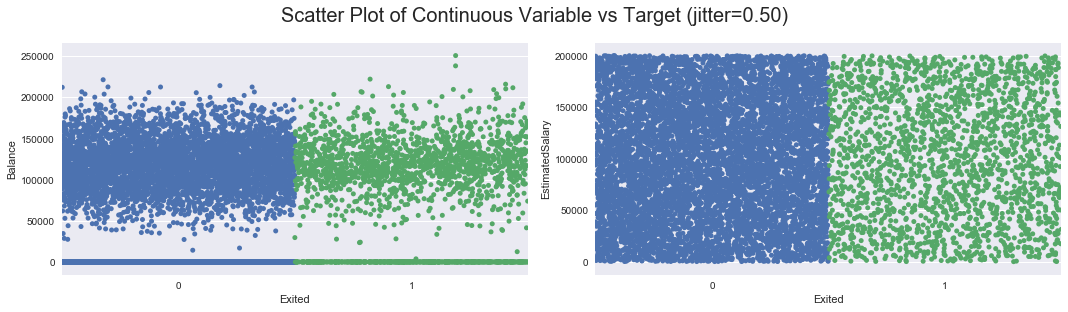

Total Number of Scatter Plots = 3


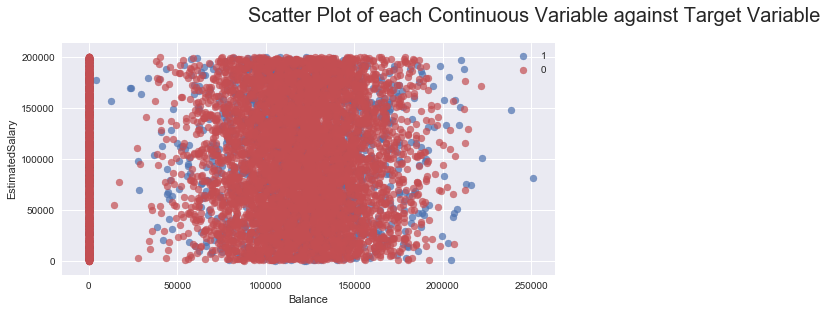

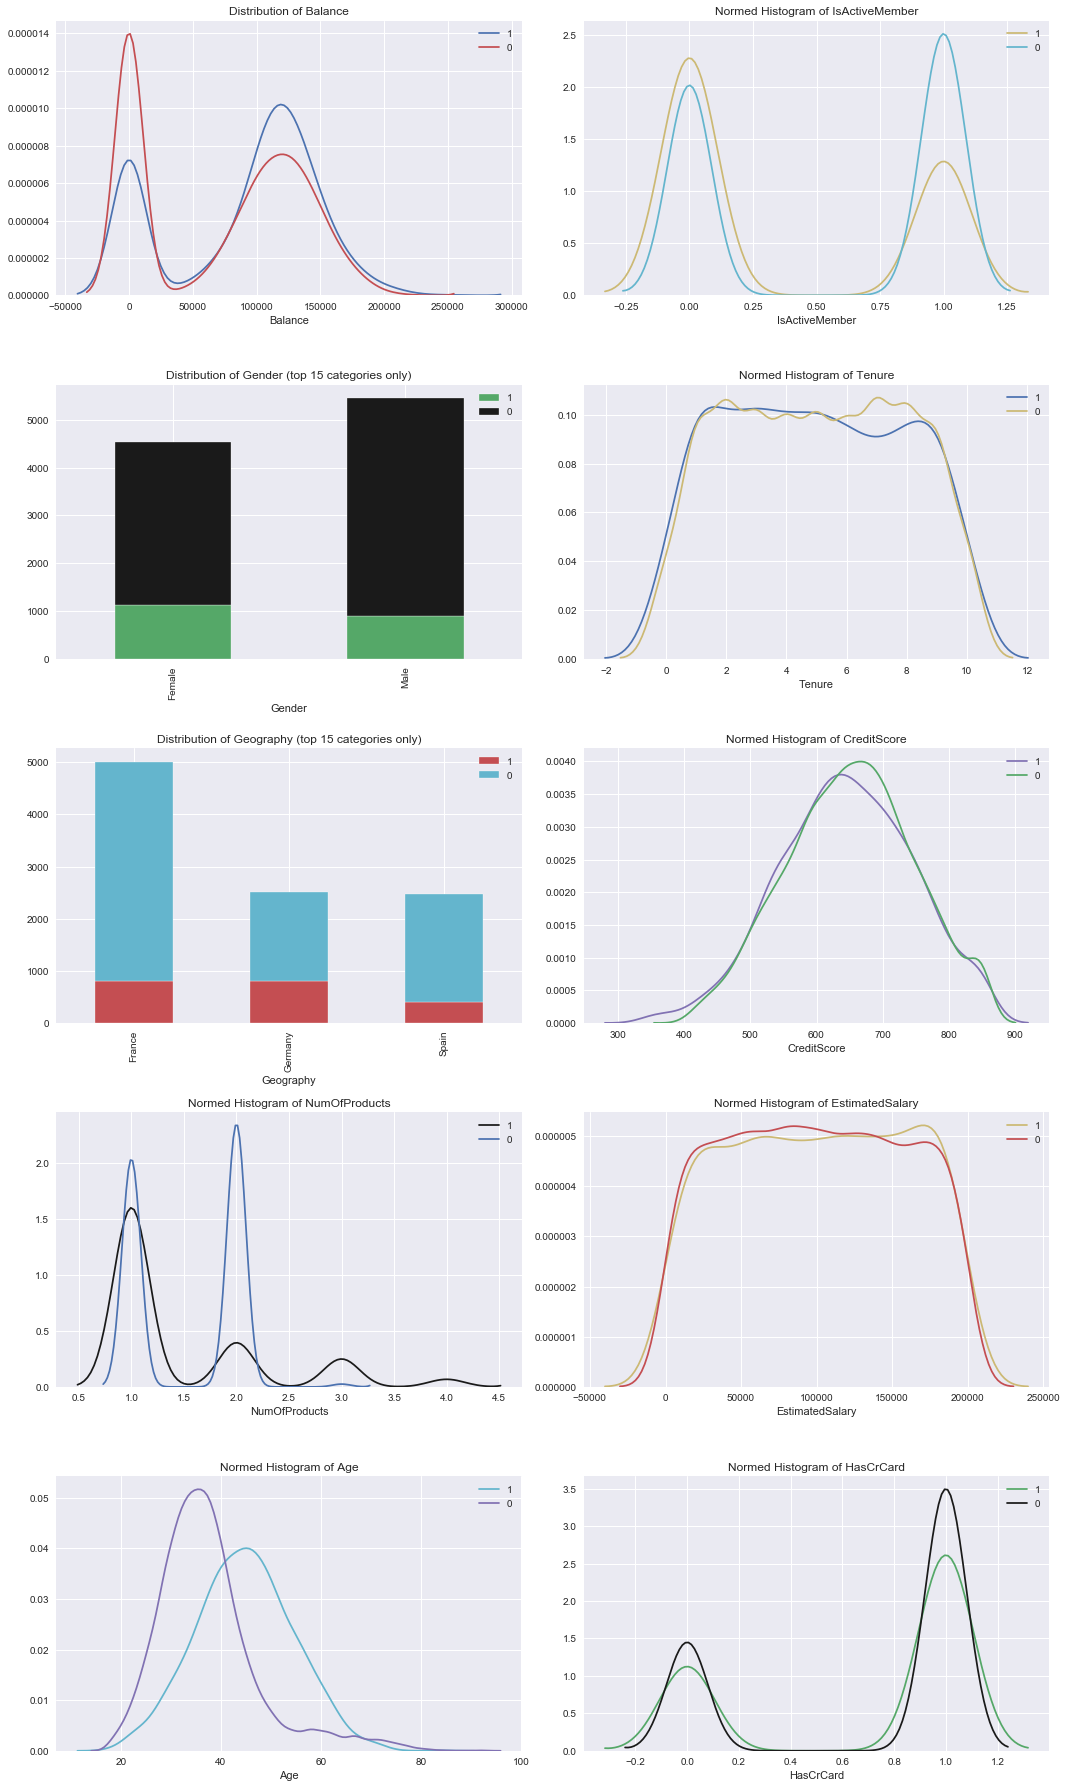

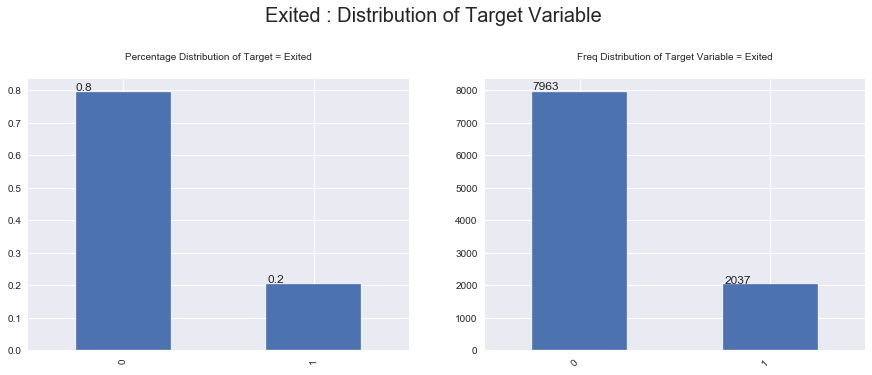

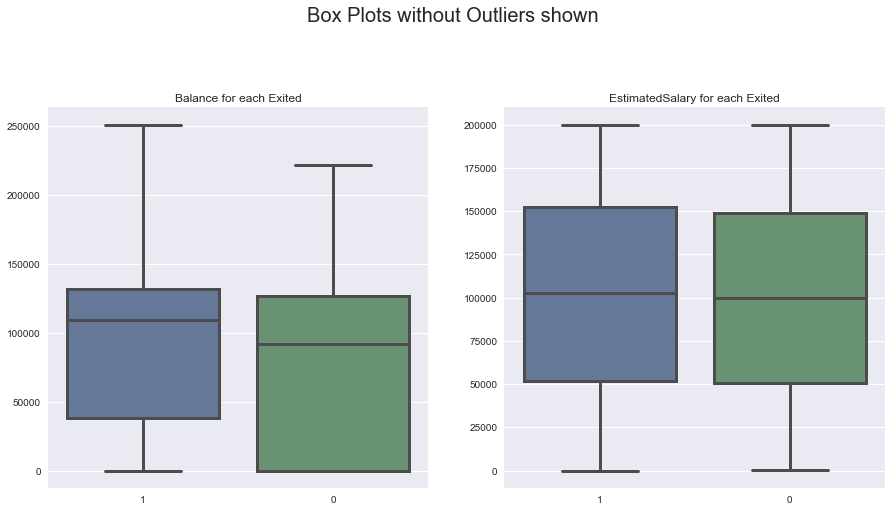

No date vars could be found in data set


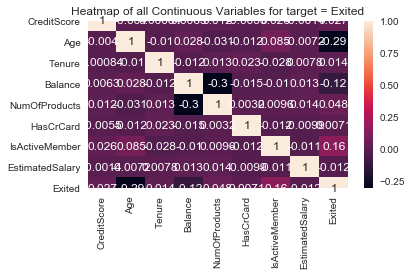

No. of Bar Plots = 28.0


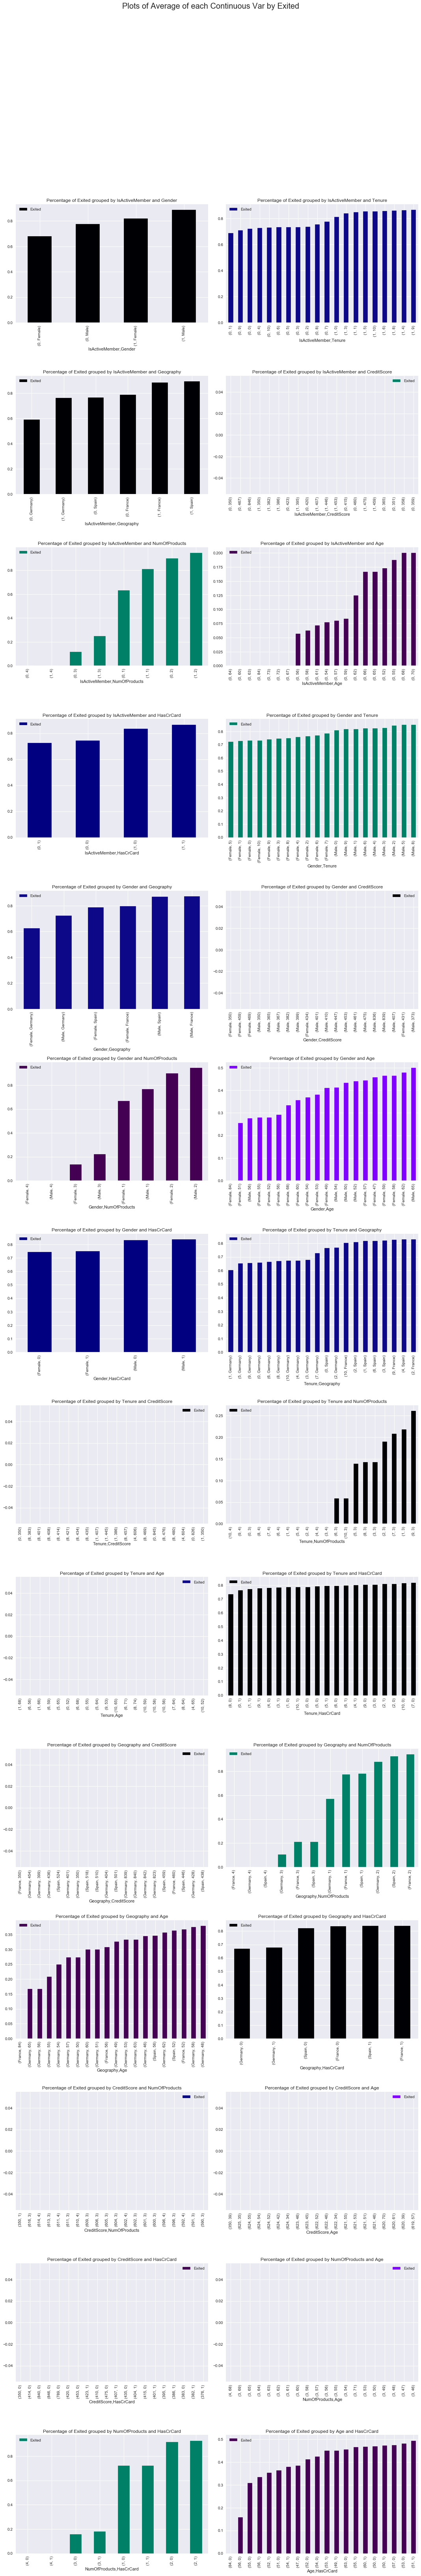

Nothing to add Plot not being added
All plots done
Time to run AutoViz (in seconds) = 21.918

 ###################### VISUALIZATION Completed ########################


In [11]:
from autoviz.AutoViz_Class import AutoViz_Class

AV = AutoViz_Class()
dft = AV.AutoViz(
    '',
    ',',
    'Exited',
    df,
    header=0,
    verbose=1,
    lowess=False,
    chart_format="svg",
    max_rows_analyzed=15000,
    max_cols_analyzed=200,
)

## Insights:
Almost all the column distributions are overlapping based on KDE plots

In [12]:
#Separating catagorical and numerical columns
Id_col = ['CustomerId']
target_col = ["Exited"]
cat_cols = df.nunique()[df.nunique() < 6].keys().tolist()
cat_cols = [x for x in cat_cols if x not in target_col]
num_cols = [x for x in df.columns if x not in cat_cols + target_col + Id_col]
#Separating churn and non churn customers
Exited = df[df["Exited"] == 1]
not_Exited = df[df["Exited"] == 0]

In [13]:
#function  for pie plot for customer attrition types
def plot_pie(column):

    trace1 = go.Pie(values=Exited[column].value_counts().values.tolist(),
                    labels=Exited[column].value_counts().keys().tolist(),
                    hoverinfo="label+percent+name",
                    domain=dict(x=[0, .48]),
                    name="Exited Customers",
                    marker=dict(line=dict(width=2, color="rgb(243,243,243)")),
                    hole=.6)
    trace2 = go.Pie(values=not_Exited[column].value_counts().values.tolist(),
                    labels=not_Exited[column].value_counts().keys().tolist(),
                    hoverinfo="label+percent+name",
                    marker=dict(line=dict(width=2, color="rgb(243,243,243)")),
                    domain=dict(x=[.52, 1]),
                    hole=.6,
                    name="Non Exited customers")

    layout = go.Layout(
        dict(title=column + " distribution in customer attrition ",
             plot_bgcolor="rgb(243,243,243)",
             paper_bgcolor="rgb(243,243,243)",
             annotations=[
                 dict(text="Exited customers",
                      font=dict(size=13),
                      showarrow=False,
                      x=.15,
                      y=.5),
                 dict(text="Non Exited customers",
                      font=dict(size=13),
                      showarrow=False,
                      x=.88,
                      y=.5)
             ]))
    data = [trace1, trace2]
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)


#for all categorical columns plot pie
for i in cat_cols:
    plot_pie(i)

In [14]:
#function  for histogram for customer attrition types
def histogram(column):
    trace1 = go.Histogram(x=Exited[column],
                          histnorm="percent",
                          name="Exited Customers",
                          marker=dict(line=dict(width=.5, color="black")),
                          opacity=.9)

    trace2 = go.Histogram(x=not_Exited[column],
                          histnorm="percent",
                          name="Non Exited customers",
                          marker=dict(line=dict(width=.5, color="black")),
                          opacity=.9)

    data = [trace1, trace2]
    layout = go.Layout(
        dict(
            title=column + " distribution in customer attrition ",
            plot_bgcolor="rgb(243,243,243)",
            paper_bgcolor="rgb(243,243,243)",
            xaxis=dict(gridcolor='rgb(255, 255, 255)',
                       title=column,
                       zerolinewidth=1,
                       ticklen=5,
                       gridwidth=2),
            yaxis=dict(gridcolor='rgb(255, 255, 255)',
                       title="percent",
                       zerolinewidth=1,
                       ticklen=5,
                       gridwidth=2),
        ))
    fig = go.Figure(data=data, layout=layout)

    py.iplot(fig)


#for all Numeric columns plot histogram
for i in num_cols:
    histogram(i)

# Preprocessing

In [9]:
#Drop 'RowNumber','Surname' as they are useless in prediction
df.drop(['RowNumber', 'Surname', 'CustomerId'], axis=1, inplace=True)

# Make age as bins so that we generalise the model
df['Age'] = pd.qcut(df['Age'], 10)

# round off the decimals and tens place in Creditscore column
df['CreditScore'] = df['CreditScore'].round(-1)

# Balance column has lot of nuumeric data with full unique numbers,
# lets round it off to hundreds place
df['Balance'] = df['Balance'].round(-2)

# EstimatedSalary column has lot of nuumeric data with full unique numbers,
# lets round it off to hundreds place
df['EstimatedSalary'] = df['EstimatedSalary'].round(-2)

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#customer id col
Id_col = ['']
#Target columns
target_col = ["Exited"]
#categorical columns
cat_cols = df.nunique()[df.nunique() <= 10].keys().tolist()
cat_cols = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols = [x for x in df.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols = df.nunique()[df.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols:
    df[i] = le.fit_transform(df[i])

#Duplicating columns for multi value columns
df = pd.get_dummies(data=df, columns=multi_cols)

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled, columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_telcom_og = df.copy()
df = df.drop(columns=num_cols, axis=1)
df = df.merge(scaled, left_index=True, right_index=True, how="left")

In [12]:
df

Gender  HasCrCard  IsActiveMember  ...    Tenure   Balance  EstimatedSalary
0          0          1               1  ... -1.041760 -1.225846         0.021027
1          0          0               1  ... -1.387538  0.117221         0.215784
2          0          1               0  ...  1.032908  1.333675         0.240129
3          0          0               0  ... -1.387538 -1.225846        -0.109390
4          0          1               1  ... -1.041760  0.785550        -0.365008
...      ...        ...             ...  ...       ...       ...              ...
9995       1          1               0  ... -0.004426 -1.225846        -0.065918
9996       1          1               1  ...  1.724464 -0.305893         0.027983
9997       0          0               1  ...  0.687130 -1.225846        -1.008402
9998       1          1               0  ... -0.695982 -0.022214        -0.125040
9999       0          1               0  ... -0.350204  0.859274        -1.076219

[10000 rows x 25 columns]

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X = df[[i for i in df.columns if i not in target_col]]
Y = df[target_col]

principal_components = pca.fit_transform(X)
pca_data = pd.DataFrame(principal_components, columns=["PC1", "PC2"])
pca_data = pca_data.merge(Y, left_index=True, right_index=True, how="left")
pca_data["Exited"] = pca_data["Exited"].replace({1: "Exited", 0: "Not Exited"})


def pca_scatter(target, color):
    tracer = go.Scatter(x=pca_data[pca_data["Exited"] == target]["PC1"],
                        y=pca_data[pca_data["Exited"] == target]["PC2"],
                        name=target,
                        mode="markers",
                        marker=dict(color=color,
                                    line=dict(width=.5),
                                    symbol="diamond-open"),
                        text=())
    return tracer


layout = go.Layout(
    dict(title="Visualising data with principal components",
         plot_bgcolor="rgb(243,243,243)",
         paper_bgcolor="rgb(243,243,243)",
         xaxis=dict(gridcolor='rgb(255, 255, 255)',
                    title="principal component 1",
                    zerolinewidth=1,
                    ticklen=5,
                    gridwidth=2),
         yaxis=dict(gridcolor='rgb(255, 255, 255)',
                    title="principal component 2",
                    zerolinewidth=1,
                    ticklen=5,
                    gridwidth=2),
         height=600))
trace1 = pca_scatter("Exited", 'red')
trace2 = pca_scatter("Not Exited", 'royalblue')
data = [trace2, trace1]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## Insights
1. Data is not linearly seperable, we must try with Deep Learning for better results

# Split the data into train,test,validation

In [13]:
X_train, X_val, y_train, y_val = train_test_split(df.drop('Exited', axis=1),
                                                  df['Exited'],
                                                  test_size=0.1,
                                                  stratify=df['Exited'])

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.2,
                                                    stratify=y_train)

In [14]:
X_train.shape

(7200, 24)

# Basic Keras Model

In [20]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


In [35]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=24))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [36]:
basic_model=model.fit(X_train, y_train, epochs=10, batch_size=100,validation_data=(X_test,y_test))

Train on 7200 samples, validate on 1800 samples
Epoch 1/10
7200/7200 [==============================] - ETA: 7s - loss: 0.7570 - accuracy: 0.40 - ETA: 0s - loss: 0.6178 - accuracy: 0.69 - ETA: 0s - loss: 0.5676 - accuracy: 0.74 - 0s 40us/step - loss: 0.5533 - accuracy: 0.7504 - val_loss: 0.4676 - val_accuracy: 0.8011
Epoch 2/10
7200/7200 [==============================] - ETA: 0s - loss: 0.4642 - accuracy: 0.80 - ETA: 0s - loss: 0.4667 - accuracy: 0.79 - ETA: 0s - loss: 0.4503 - accuracy: 0.80 - 0s 22us/step - loss: 0.4459 - accuracy: 0.8021 - val_loss: 0.4167 - val_accuracy: 0.8167
Epoch 3/10
7200/7200 [==============================] - ETA: 0s - loss: 0.3776 - accuracy: 0.86 - ETA: 0s - loss: 0.4050 - accuracy: 0.81 - ETA: 0s - loss: 0.4026 - accuracy: 0.82 - ETA: 0s - loss: 0.4012 - accuracy: 0.82 - 0s 27us/step - loss: 0.4009 - accuracy: 0.8222 - val_loss: 0.3843 - val_accuracy: 0.8406
Epoch 4/10
7200/7200 [==============================] - ETA: 0s - loss: 0.3647 - accuracy: 0.85 -

In [39]:
from sklearn.metrics import confusion_matrix, f1_score
y_pred = basic_model.model.predict_classes(X_val)
print(confusion_matrix(y_pred, y_val))
print(f1_score(y_pred, y_val))

[[768 127]
 [ 28  77]]
0.49838187702265363


In [23]:
#plot test vs train accuracy
import plotly.graph_objs as go  #visualization
import pandas as pd


def plot_test_vs_train(model, is_loss):
    df = pd.DataFrame(model.history, index=model.epoch)
    if ((df.loss[0] - df.loss[1]) > 100):
        df = df.drop(0)
    holder_string = ''
    if is_loss == 'Yes':
        holder_string = 'loss'
    else:
        holder_string = 'accuracy'
    trace_1 = {
        "mode": "lines+markers",
        "name": "Train " + holder_string,
        "type": "scatter",
        "x": df.index,
        "y": df[holder_string]
    }
    trace_2 = {
        "mode": "lines+markers",
        "name": "Test " + holder_string,
        "type": "scatter",
        "x": df.index,
        "y": df['val_' + holder_string]
    }

    data = [trace_1, trace_2]
    layout = {
        "title": "Training vs Testing Data " + holder_string + " per Epoch",
        "xaxis": {
            "title": "Epoch"
        },
        "yaxis": {
            "title": holder_string
        }
    }
    fig = go.Figure(data=data, layout=layout)
    fig.show()

In [24]:
plot_test_vs_train(basic_model,'No')

In [25]:
plot_test_vs_train(basic_model,'Yes')

## Insights:
1. Data is imbalanced, if we predict all customers as 0, then we will get an accuracy of 80%
2. We should look at different metrics like F1 score which is good to look at imbalanced datasets.
3. We will Tune the hyper-parameters using TALOS which is tuning library and gives very flexible way to tune them.

# Hyperparameter tuing using TALOS

In [54]:
from talos.model import normalizers
from keras.optimizers import Adam, Nadam, SGD, RMSprop
from keras.activations import relu, tanh, elu
from keras.losses import binary_crossentropy, logcosh
import talos
import keras
from keras.models import Sequential
from talos.utils import metrics
from keras.layers import Dense, Dropout

p = {
    'activation': [relu, elu],
    'optimizer': [Adam, Nadam, RMSprop],
    'losses': [binary_crossentropy, logcosh],
    'shapes': ['brick', 'funnel'],
    'first_neuron': [24, 48, 72],
    'hidden_layers': [0, 1, 2],
    'dropout': (0, 0.5, 5),
    'batch_size': (100, 500, 10),
    'lr': (0.5, 1, 5),
    'epochs': [100, 200]
}


def bank_churn_hyper_tuning(x_train, y_train, x_val, y_val, params):

    model = Sequential()
    model.add(
        Dense(params['first_neuron'],
              input_dim=x_train.shape[1],
              activation=params['activation']))

    talos.utils.hidden_layers(model, params, 1)

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=params['optimizer'](
        lr=normalizers.lr_normalizer(params['lr'], params['optimizer'])),
                  loss=params['losses'],
                  metrics=['acc', metrics.f1score])

    out = model.fit(
        x_train,
        y_train,
        callbacks=[
            talos.utils.early_stopper(30),
            talos.utils.ExperimentLogCallback('bank_churn_prediction_test_1',
                                              params),
            #                         talos.utils.live()
        ],
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        validation_data=[x_val, y_val],
        verbose=0)

    return out, model


scan_object = talos.Scan(X_train,
                         y_train,
                         model=bank_churn_hyper_tuning,
                         experiment_name='bank_churn_prediction_test_1',
                         params=p,
                         x_val=X_test,
                         y_val=y_test,
                         reduction_method='correlation',
                         fraction_limit=0.02)







  0%|          | 0/2160 [00:00<?, ?it/s]





  0%|          | 1/2160 [00:03<2:20:17,  3.90s/it]





  0%|          | 2/2160 [00:10<2:51:01,  4.76s/it]





  0%|          | 3/2160 [00:14<2:44:54,  4.59s/it]





  0%|          | 4/2160 [00:18<2:33:48,  4.28s/it]





  0%|          | 5/2160 [00:22<2:30:41,  4.20s/it]





  0%|          | 6/2160 [00:27<2:43:15,  4.55s/it]





  0%|          | 7/2160 [00:32<2:46:20,  4.64s/it]





  0%|          | 8/2160 [00:36<2:38:56,  4.43s/it]





  0%|          | 9/2160 [00:41<2:40:33,  4.48s/it]





  0%|          | 10/2160 [00:45<2:36:58,  4.38s/it]





  1%|          | 11/2160 [00:48<2:22:49,  3.99s/it]





  1%|          | 12/2160 [00:55<2:50:58,  4.78s/it]





  1%|          | 13/2160 [01:00<2:58:11,  4.98s/it]





  1%|          | 14/2160 [01:06<3:04:14,  5.15s/it]





  1%|          | 15/2160 [01:15<3:45:26,  6.31s/it]





  1%|          | 16/2160 [01:22<3:53:06,  6.52s/it]





  1%|          | 17/2160 [01:26<3:33:27,  5.9

Total 33.7% permutations reduced








 37%|███▋      | 794/2160 [09:00<1:24:16,  3.70s/it]





 37%|███▋      | 795/2160 [09:00<1:27:18,  3.84s/it]





 37%|███▋      | 796/2160 [09:07<1:49:14,  4.81s/it]





 37%|███▋      | 797/2160 [09:13<1:53:08,  4.98s/it]





 37%|███▋      | 798/2160 [09:17<1:50:00,  4.85s/it]





 37%|███▋      | 799/2160 [09:22<1:46:27,  4.69s/it]





 37%|███▋      | 800/2160 [09:33<2:34:11,  6.80s/it]





 37%|███▋      | 801/2160 [09:39<2:25:13,  6.41s/it]





 37%|███▋      | 802/2160 [09:43<2:12:06,  5.84s/it]





 37%|███▋      | 803/2160 [09:48<2:04:55,  5.52s/it]





 37%|███▋      | 804/2160 [09:53<1:58:45,  5.25s/it]





 37%|███▋      | 805/2160 [09:59<2:04:42,  5.52s/it]





 37%|███▋      | 806/2160 [10:03<1:57:16,  5.20s/it]





 37%|███▋      | 807/2160 [10:08<1:54:20,  5.07s/it]





 37%|███▋      | 808/2160 [10:12<1:47:41,  4.78s/it]





 37%|███▋      | 809/2160 [10:17<1:49:32,  4.86s/it]





 38%|███▊      | 810/2160 [10:22<1:45:34,  4.69s/it]





 38%|███

Total 33.0% permutations reduced








 59%|█████▉    | 1280/2160 [13:37<45:02,  3.07s/it]





 59%|█████▉    | 1281/2160 [13:37<50:08,  3.42s/it]





 59%|█████▉    | 1282/2160 [13:43<58:36,  4.01s/it]





 59%|█████▉    | 1283/2160 [13:47<57:49,  3.96s/it]





 59%|█████▉    | 1284/2160 [13:54<1:10:56,  4.86s/it]





 59%|█████▉    | 1285/2160 [13:59<1:11:54,  4.93s/it]





 60%|█████▉    | 1286/2160 [14:04<1:12:36,  4.98s/it]





 60%|█████▉    | 1287/2160 [14:10<1:19:34,  5.47s/it]





 60%|█████▉    | 1288/2160 [14:15<1:14:05,  5.10s/it]





 60%|█████▉    | 1289/2160 [14:19<1:12:26,  4.99s/it]





 60%|█████▉    | 1290/2160 [14:24<1:12:45,  5.02s/it]





 60%|█████▉    | 1291/2160 [14:29<1:10:00,  4.83s/it]





 60%|█████▉    | 1292/2160 [14:35<1:14:05,  5.12s/it]





 60%|█████▉    | 1293/2160 [14:40<1:16:20,  5.28s/it]





 60%|█████▉    | 1294/2160 [14:46<1:16:13,  5.28s/it]





 60%|█████▉    | 1295/2160 [14:50<1:11:04,  4.93s/it]





 60%|██████    | 1296/2160 [14:53<1:05:54,  4.58s/it]






Total 20.3% permutations reduced








 69%|██████▉   | 1498/2160 [17:46<42:15,  3.83s/it]





 69%|██████▉   | 1500/2160 [17:56<45:36,  4.15s/it]





 69%|██████▉   | 1501/2160 [18:01<48:18,  4.40s/it]





 70%|██████▉   | 1502/2160 [18:06<49:56,  4.55s/it]





 70%|██████▉   | 1503/2160 [18:11<53:08,  4.85s/it]





 70%|██████▉   | 1504/2160 [18:15<51:00,  4.67s/it]





 70%|██████▉   | 1505/2160 [18:20<50:14,  4.60s/it]





 70%|██████▉   | 1506/2160 [18:28<1:02:17,  5.71s/it]





 70%|██████▉   | 1507/2160 [18:33<1:00:27,  5.56s/it]





 70%|██████▉   | 1508/2160 [18:39<1:01:35,  5.67s/it]





 70%|██████▉   | 1509/2160 [18:44<57:40,  5.32s/it]  





 70%|██████▉   | 1510/2160 [18:49<57:16,  5.29s/it]





 70%|██████▉   | 1511/2160 [18:54<55:08,  5.10s/it]





 70%|███████   | 1512/2160 [18:58<52:26,  4.86s/it]





 70%|███████   | 1513/2160 [19:02<51:14,  4.75s/it]





 70%|███████   | 1514/2160 [19:08<53:56,  5.01s/it]





 70%|███████   | 1515/2160 [19:13<53:24,  4.97s/it]





 70%|███████   | 

Total 19.6% permutations reduced








 77%|███████▋  | 1668/2160 [22:08<29:31,  3.60s/it]





 77%|███████▋  | 1669/2160 [22:15<37:30,  4.58s/it]





 77%|███████▋  | 1670/2160 [22:22<43:16,  5.30s/it]





 77%|███████▋  | 1671/2160 [22:27<43:22,  5.32s/it]





 77%|███████▋  | 1672/2160 [22:32<41:18,  5.08s/it]





 77%|███████▋  | 1673/2160 [22:38<44:27,  5.48s/it]





 78%|███████▊  | 1674/2160 [22:44<46:04,  5.69s/it]





 78%|███████▊  | 1675/2160 [22:50<46:09,  5.71s/it]





 78%|███████▊  | 1676/2160 [22:56<46:40,  5.79s/it]





 78%|███████▊  | 1677/2160 [23:02<46:22,  5.76s/it]





 78%|███████▊  | 1678/2160 [23:10<51:44,  6.44s/it]





 78%|███████▊  | 1679/2160 [23:14<46:12,  5.76s/it]





 78%|███████▊  | 1680/2160 [23:19<44:28,  5.56s/it]





 78%|███████▊  | 1681/2160 [23:25<44:48,  5.61s/it]





 78%|███████▊  | 1682/2160 [23:29<40:51,  5.13s/it]





 78%|███████▊  | 1683/2160 [23:33<38:52,  4.89s/it]





 78%|███████▊  | 1684/2160 [23:38<38:30,  4.85s/it]





 78%|███████▊  | 1685/216

Total 49.7% permutations reduced








 90%|████████▉ | 1937/2160 [26:54<14:22,  3.87s/it]





 90%|████████▉ | 1938/2160 [26:59<15:49,  4.28s/it]





 90%|████████▉ | 1939/2160 [27:06<18:32,  5.03s/it]





 90%|████████▉ | 1940/2160 [27:11<18:20,  5.00s/it]





 90%|████████▉ | 1941/2160 [27:21<24:05,  6.60s/it]





 90%|████████▉ | 1942/2160 [27:28<23:42,  6.53s/it]





 90%|████████▉ | 1943/2160 [27:32<21:20,  5.90s/it]





 90%|█████████ | 1944/2160 [27:37<20:33,  5.71s/it]





 90%|█████████ | 1945/2160 [27:42<19:43,  5.51s/it]





 90%|█████████ | 1946/2160 [27:48<19:55,  5.59s/it]





 90%|█████████ | 1947/2160 [27:52<17:54,  5.04s/it]





 90%|█████████ | 1948/2160 [27:57<17:42,  5.01s/it]





 90%|█████████ | 1949/2160 [28:01<17:05,  4.86s/it]





 90%|█████████ | 1950/2160 [28:05<16:14,  4.64s/it]





 90%|█████████ | 1951/2160 [28:11<16:39,  4.78s/it]





 90%|█████████ | 1952/2160 [28:16<16:47,  4.84s/it]





 90%|█████████ | 1953/2160 [28:20<15:56,  4.62s/it]





 90%|█████████ | 1954/216

Total 54.8% permutations reduced








 98%|█████████▊| 2127/2160 [40:14<01:45,  3.21s/it]





 99%|█████████▊| 2128/2160 [40:19<01:56,  3.64s/it]





 99%|█████████▊| 2129/2160 [40:24<02:09,  4.17s/it]





 99%|█████████▊| 2130/2160 [40:30<02:20,  4.68s/it]





 99%|█████████▊| 2131/2160 [40:34<02:14,  4.62s/it]





 99%|█████████▊| 2132/2160 [40:41<02:24,  5.15s/it]





 99%|█████████▉| 2133/2160 [40:45<02:12,  4.92s/it]





 99%|█████████▉| 2134/2160 [40:50<02:07,  4.90s/it]





 99%|█████████▉| 2135/2160 [40:57<02:18,  5.54s/it]





 99%|█████████▉| 2136/2160 [41:02<02:08,  5.36s/it]





 99%|█████████▉| 2137/2160 [41:07<01:59,  5.20s/it]





 99%|█████████▉| 2138/2160 [41:13<01:58,  5.41s/it]





 99%|█████████▉| 2139/2160 [41:18<01:53,  5.40s/it]





 99%|█████████▉| 2140/2160 [41:25<01:54,  5.70s/it]





 99%|█████████▉| 2141/2160 [41:29<01:43,  5.45s/it]





 99%|█████████▉| 2142/2160 [41:34<01:35,  5.30s/it]





 99%|█████████▉| 2143/2160 [41:42<01:44,  6.13s/it]





 99%|█████████▉| 2144/216

In [55]:
# use Scan object as input
analyze_object = talos.Analyze(scan_object)

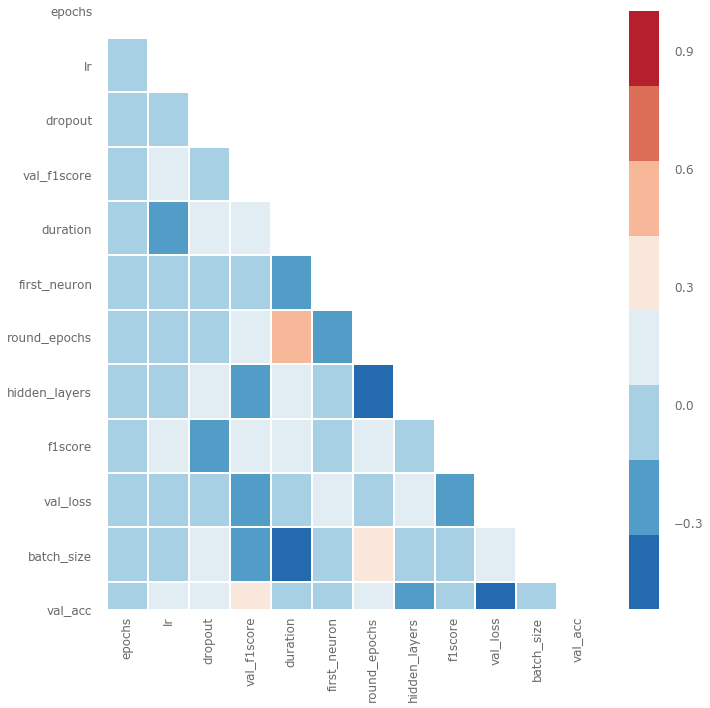

In [56]:
# Lets check the correlation between all the hyperparams and then we can try to tune acccordingly
analyze_object.plot_corr('val_loss', ['acc', 'loss', 'val_loss'])

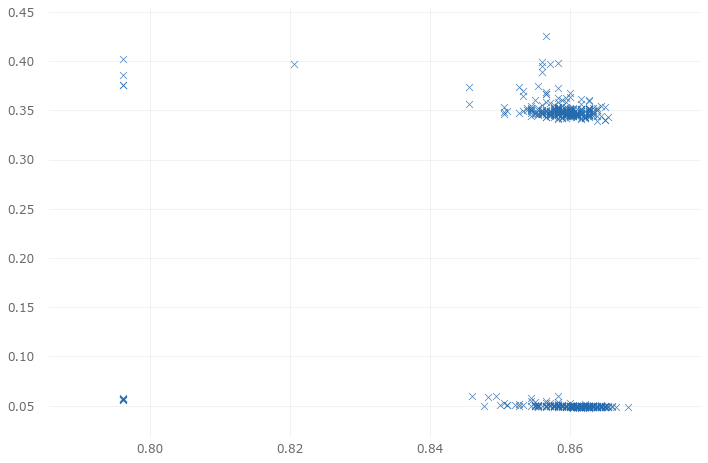

In [57]:
# a regression plot for accuracy vs loss of test data
analyze_object.plot_regs('val_acc', 'val_loss')

In [59]:
# Get all the scan results into a datafram and check the top5 models
results = scan_object.data
results.sort_values(by='val_f1score', ascending=False).head(5)

start              end  duration  round_epochs  val_loss  \
126  05/08/20-134734  05/08/20-134738  3.888996            41  0.049031   
251  05/08/20-135830  05/08/20-135836  5.230001            44  0.052841   
427  05/08/20-141434  05/08/20-141438  4.436000            62  0.048686   
464  05/08/20-141750  05/08/20-141756  6.018993            79  0.048329   
149  05/08/20-134938  05/08/20-134940  2.154004            16  0.050390   

      val_acc  val_f1score      loss       acc   f1score  \
126  0.863333     0.608365  0.047718  0.863194  0.586365   
251  0.856667     0.607096  0.050503  0.864306  0.617978   
427  0.866667     0.605215  0.046658  0.865139  0.583216   
464  0.863889     0.604955  0.047000  0.865694  0.590706   
149  0.855000     0.603838  0.046579  0.867222  0.602546   

                                activation  batch_size  dropout  epochs  \
126  <function relu at 0x0000022C179D7C18>         220      0.3     100   
251  <function relu at 0x0000022C179D7C18>         220      0.1     200   
427  <function relu at 0x0000022C179D7C18>         220      0.1     100   
464   <function elu at 0x0000022C179D7048>         220      0.0     100   
149  <function relu at 0x0000022C179D7C18>         220      0.0     200   

     first_neuron  hidden_layers                                    losses  \
126            24              0  <function logcosh at 0x0000022C17975558>   
251            48              2  <function logcosh at 0x0000022C17975558>   
427            48              0  <function logcosh at 0x0000022C17975558>   
464            48              0  <function logcosh at 0x0000022C17975558>   
149            48              2  <function logcosh at 0x0000022C17975558>   

      lr                           optimizer  shapes  
126  0.8     <class 'keras.optimizers.Adam'>  funnel  
251  0.6  <class 'keras.optimizers.RMSprop'>  funnel  
427  0.6     <class 'keras.optimizers.Adam'>  funnel  
464  0.6    <class 'keras.optimizers.Nadam'>   brick  
149  0.6  <class 'keras.optimizers.RMSprop'>   brick

In [61]:
# Get correlated values for f1_score of test data
analyze_object.correlate('val_f1score', [])

duration         0.036227
round_epochs     0.084125
val_loss        -0.019232
val_acc          0.948864
loss            -0.041728
acc              0.743989
f1score          0.902977
batch_size      -0.082277
dropout         -0.131911
epochs           0.020054
first_neuron    -0.007939
hidden_layers   -0.171144
lr               0.030498
Name: val_f1score, dtype: float64

In [62]:
#Save the best model so that it can be used for future use
talos.Deploy(scan_object=scan_object,
             model_name='bank_churn_test_1_export',
             metric='val_f1score')

Deploy package bank_churn_test_1_export have been saved.


## Next Steps:
1. Reduce the First Neuron values 
2. reduce upper limit of hidden layers
3. Reduce batch size and drop out rates too

In [63]:
from talos.model import normalizers
from keras.optimizers import Adam, Nadam, SGD, RMSprop
from keras.activations import relu, tanh, elu
from keras.losses import binary_crossentropy, logcosh
import talos
import keras
from keras.models import Sequential
from talos.utils import metrics
from keras.layers import Dense, Dropout

p = {
    'activation': [relu, elu],
    'optimizer': [Adam, RMSprop],
    'losses': [binary_crossentropy, logcosh],
    'shapes': ['brick', 'funnel'],
    'first_neuron': [24, 48],
    'hidden_layers': [0, 1],
    'dropout': (0, 0.3, 5),
    'batch_size': (10, 200, 10),
    'lr': (0.5, 1, 5),
    'epochs': [100, 150]
}


def bank_churn_hyper_tuning(x_train, y_train, x_val, y_val, params):

    model = Sequential()
    model.add(
        Dense(params['first_neuron'],
              input_dim=x_train.shape[1],
              activation=params['activation']))

    talos.utils.hidden_layers(model, params, 1)

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=params['optimizer'](
        lr=normalizers.lr_normalizer(params['lr'], params['optimizer'])),
                  loss=params['losses'],
                  metrics=['acc', metrics.f1score])

    out = model.fit(
        x_train,
        y_train,
        callbacks=[
            talos.utils.early_stopper(30),
            talos.utils.ExperimentLogCallback('bank_churn_prediction_test_2',
                                              params),
            #                         talos.utils.live()
        ],
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        validation_data=[x_val, y_val],
        verbose=0)

    return out, model


scan_object1 = talos.Scan(X_train,
                          y_train,
                          model=bank_churn_hyper_tuning,
                          experiment_name='bank_churn_prediction_test_2',
                          params=p,
                          x_val=X_test,
                          y_val=y_test,
                          reduction_method='correlation',
                          fraction_limit=0.02)







  0%|          | 0/640 [00:00<?, ?it/s]





  0%|          | 1/640 [00:06<1:06:38,  6.26s/it]





  0%|          | 2/640 [00:27<1:55:51, 10.90s/it]





  0%|          | 3/640 [00:33<1:38:23,  9.27s/it]





  1%|          | 4/640 [00:42<1:37:11,  9.17s/it]





  1%|          | 5/640 [00:48<1:28:04,  8.32s/it]





  1%|          | 6/640 [00:58<1:33:09,  8.82s/it]





  1%|          | 7/640 [01:05<1:25:35,  8.11s/it]





  1%|▏         | 8/640 [01:11<1:19:24,  7.54s/it]





  1%|▏         | 9/640 [01:18<1:19:26,  7.55s/it]





  2%|▏         | 10/640 [01:26<1:19:55,  7.61s/it]





  2%|▏         | 11/640 [01:32<1:13:42,  7.03s/it]





  2%|▏         | 12/640 [01:41<1:19:30,  7.60s/it]





  2%|▏         | 13/640 [01:47<1:15:37,  7.24s/it]





  2%|▏         | 14/640 [01:54<1:15:01,  7.19s/it]





  2%|▏         | 15/640 [02:04<1:21:49,  7.86s/it]





  2%|▎         | 16/640 [02:10<1:15:30,  7.26s/it]





  3%|▎         | 17/640 [02:18<1:18:12,  7.53s/it]





  3%|▎

Total 19.0% permutations reduced








 25%|██▌       | 161/640 [07:49<58:30,  7.33s/it]  





 25%|██▌       | 162/640 [07:55<54:49,  6.88s/it]





 25%|██▌       | 163/640 [08:08<1:09:36,  8.76s/it]





 26%|██▌       | 164/640 [08:14<1:01:54,  7.80s/it]





 26%|██▌       | 165/640 [08:19<56:01,  7.08s/it]  





 26%|██▌       | 166/640 [08:25<53:15,  6.74s/it]





 26%|██▌       | 167/640 [08:34<59:35,  7.56s/it]





 26%|██▋       | 168/640 [08:43<1:01:19,  7.80s/it]





 26%|██▋       | 169/640 [08:48<54:22,  6.93s/it]  





 27%|██▋       | 170/640 [08:55<56:00,  7.15s/it]





 27%|██▋       | 171/640 [09:04<1:00:14,  7.71s/it]





 27%|██▋       | 172/640 [09:14<1:05:04,  8.34s/it]





 27%|██▋       | 173/640 [09:34<1:31:32, 11.76s/it]





 27%|██▋       | 174/640 [09:43<1:25:13, 10.97s/it]





 27%|██▋       | 175/640 [09:56<1:30:56, 11.73s/it]





 28%|██▊       | 176/640 [10:08<1:30:34, 11.71s/it]





 28%|██▊       | 177/640 [10:15<1:18:50, 10.22s/it]





 28%|██▊       | 178/640 [10:20<1

Total 49.9% permutations reduced








 67%|██████▋   | 426/640 [14:55<22:10,  6.22s/it]





 67%|██████▋   | 427/640 [15:06<22:04,  6.22s/it]





 67%|██████▋   | 428/640 [15:10<22:57,  6.50s/it]





 67%|██████▋   | 429/640 [15:23<29:43,  8.45s/it]





 67%|██████▋   | 430/640 [15:33<31:07,  8.89s/it]





 67%|██████▋   | 431/640 [15:39<28:26,  8.16s/it]





 68%|██████▊   | 432/640 [15:45<25:25,  7.33s/it]





 68%|██████▊   | 433/640 [15:50<23:33,  6.83s/it]





 68%|██████▊   | 434/640 [15:56<22:32,  6.56s/it]





 68%|██████▊   | 435/640 [16:04<23:14,  6.80s/it]





 68%|██████▊   | 436/640 [16:10<22:38,  6.66s/it]





 68%|██████▊   | 437/640 [16:48<54:57, 16.25s/it]





 68%|██████▊   | 438/640 [16:56<45:26, 13.50s/it]





 69%|██████▊   | 439/640 [17:03<39:36, 11.82s/it]





 69%|██████▉   | 440/640 [17:10<34:19, 10.30s/it]





 69%|██████▉   | 441/640 [17:18<32:01,  9.65s/it]





 69%|██████▉   | 442/640 [17:26<30:20,  9.19s/it]





 69%|██████▉   | 443/640 [17:32<27:02,  8.24s/it]





 69%

Total 23.6% permutations reduced








 80%|████████  | 514/640 [23:15<11:05,  5.28s/it]





 80%|████████  | 515/640 [23:24<13:09,  6.32s/it]





 81%|████████  | 516/640 [23:33<14:34,  7.05s/it]





 81%|████████  | 517/640 [23:45<17:51,  8.71s/it]





 81%|████████  | 518/640 [23:53<17:25,  8.57s/it]





 81%|████████  | 519/640 [24:00<16:17,  8.08s/it]





 81%|████████▏ | 520/640 [24:08<16:10,  8.09s/it]





 81%|████████▏ | 521/640 [24:30<23:51, 12.03s/it]





 82%|████████▏ | 522/640 [24:35<19:55, 10.13s/it]





 82%|████████▏ | 523/640 [24:41<17:12,  8.83s/it]





 82%|████████▏ | 524/640 [24:52<17:59,  9.30s/it]





 82%|████████▏ | 525/640 [24:58<16:11,  8.45s/it]





 82%|████████▏ | 526/640 [25:03<14:13,  7.48s/it]





 82%|████████▏ | 527/640 [25:30<24:59, 13.27s/it]





 82%|████████▎ | 528/640 [25:40<23:07, 12.39s/it]





 83%|████████▎ | 529/640 [25:47<19:32, 10.57s/it]





 83%|████████▎ | 530/640 [25:59<20:14, 11.04s/it]





 83%|████████▎ | 531/640 [26:04<16:54,  9.31s/it]





 83%

Total 3.9% permutations reduced








 89%|████████▊ | 567/640 [31:03<06:21,  5.23s/it]





 89%|████████▉ | 568/640 [31:13<07:56,  6.62s/it]





 89%|████████▉ | 569/640 [31:19<07:36,  6.43s/it]





 89%|████████▉ | 570/640 [31:27<08:16,  7.09s/it]





 89%|████████▉ | 571/640 [31:39<09:41,  8.43s/it]





 89%|████████▉ | 572/640 [31:48<09:54,  8.74s/it]





 90%|████████▉ | 573/640 [31:56<09:20,  8.36s/it]





 90%|████████▉ | 574/640 [32:04<08:57,  8.15s/it]





 90%|████████▉ | 575/640 [32:12<08:57,  8.26s/it]





 90%|█████████ | 576/640 [32:18<07:58,  7.48s/it]





 90%|█████████ | 577/640 [32:23<07:04,  6.74s/it]





 90%|█████████ | 578/640 [32:29<06:40,  6.46s/it]





 90%|█████████ | 579/640 [32:35<06:25,  6.31s/it]





 91%|█████████ | 580/640 [32:45<07:24,  7.41s/it]





 91%|█████████ | 581/640 [32:52<07:17,  7.41s/it]





 91%|█████████ | 582/640 [32:58<06:45,  6.99s/it]





 91%|█████████ | 583/640 [33:03<06:08,  6.46s/it]





 91%|█████████▏| 584/640 [33:08<05:33,  5.95s/it]





 91%

In [64]:
# use Scan object as input
analyze_object = talos.Analyze(scan_object1)

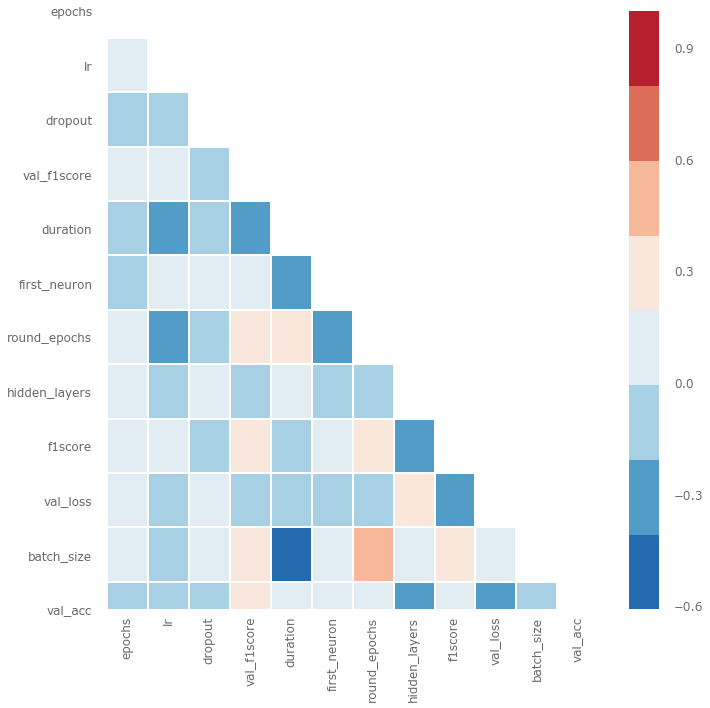

In [65]:
analyze_object.plot_corr('val_loss', ['acc', 'loss', 'val_loss'])

In [66]:
results1=scan_object1.data
results1.sort_values(by='val_f1score',ascending=False).head(5)

start              end  duration  round_epochs  val_loss  \
218  05/08/20-151038  05/08/20-151043  4.733997            59  0.048625   
17   05/08/20-143935  05/08/20-143944  8.524999            62  0.358355   
179  05/08/20-150509  05/08/20-150513  4.283999            30  0.344183   
38   05/08/20-144229  05/08/20-144232  3.479998            19  0.347320   
178  05/08/20-150501  05/08/20-150507  6.119994            60  0.048803   

      val_acc  val_f1score      loss       acc   f1score  \
218  0.864444     0.608339  0.047822  0.862222  0.586966   
17   0.865000     0.608075  0.369717  0.855000  0.554621   
179  0.862778     0.607977  0.329017  0.866389  0.596018   
38   0.858889     0.607143  0.344320  0.857361  0.562221   
178  0.865556     0.601290  0.048266  0.859444  0.564815   

                                activation  batch_size  dropout  epochs  \
218  <function relu at 0x0000022C179D7C18>         162     0.06     150   
17    <function elu at 0x0000022C179D7048>         105     0.06     100   
179  <function relu at 0x0000022C179D7C18>         105     0.12     150   
38    <function elu at 0x0000022C179D7048>         105     0.00     150   
178  <function relu at 0x0000022C179D7C18>         162     0.00     150   

     first_neuron  hidden_layers  \
218            24              0   
17             24              1   
179            48              0   
38             48              1   
178            24              0   

                                                losses   lr  \
218           <function logcosh at 0x0000022C17975558>  0.5   
17   <function binary_crossentropy at 0x0000022C179...  0.8   
179  <function binary_crossentropy at 0x0000022C179...  0.8   
38   <function binary_crossentropy at 0x0000022C179...  0.6   
178           <function logcosh at 0x0000022C17975558>  0.5   

                              optimizer  shapes  
218  <class 'keras.optimizers.RMSprop'>   brick  
17   <class 'keras.optimizers.RMSprop'>  funnel  
179  <class 'keras.optimizers.RMSprop'>   brick  
38   <class 'keras.optimizers.RMSprop'>   brick  
178     <class 'keras.optimizers.Adam'>   brick

In [76]:
talos.Deploy(scan_object=scan_object1, model_name='bank_churn_test_2_export12', metric='val_acc');

Deploy package bank_churn_test_2_export12 have been saved.


## Test the Results:
1. Lets compare first and second run of talos
2. validate the resuts on holdout data and we can pick what worked better for us

In [83]:
bank_churn = talos.Restore('bank_churn_test_1_export.zip')
# make predictions with the model
y_pred = bank_churn.model.predict_classes(X_val)
from sklearn.metrics import classification_report, f1_score, confusion_matrix
print(confusion_matrix(y_pred, y_val))
print(f1_score(y_pred, y_val))

[[767 123]
 [ 29  81]]
0.5159235668789809


In [84]:
bank_churn = talos.Restore('bank_churn_test_2_export12.zip')
# make predictions with the model
y_pred = bank_churn.model.predict_classes(X_val)
from sklearn.metrics import classification_report, f1_score, confusion_matrix
print(confusion_matrix(y_pred, y_val))
print(f1_score(y_pred, y_val))

[[766 123]
 [ 30  81]]
0.5142857142857142


## Final Verdict:

The first run worked better as the f1 score is good compared to second run

## SMOTE:

We will try once again with SMOTE applied and then check if we get any good results

In [89]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

### Tune using TALOS

In [95]:
from talos.model import normalizers
from keras.optimizers import Adam, Nadam, SGD, RMSprop
from keras.activations import relu, tanh, elu
from keras.losses import binary_crossentropy, logcosh
import talos
import keras
from keras.models import Sequential
from talos.utils import metrics
from keras.layers import Dense, Dropout

p = {
    'activation': [relu, elu],
    'optimizer': [Adam, Nadam, RMSprop],
    'losses': [binary_crossentropy, logcosh],
    'shapes': ['brick', 'funnel'],
    'first_neuron': [24, 48, 72],
    'hidden_layers': [0, 1, 2],
    'dropout': (0, 0.5, 5),
    'batch_size': (100, 500, 10),
    'lr': (0.5, 1, 5),
    'epochs': [100, 200]
}


def bank_churn_hyper_tuning(x_train, y_train, x_val, y_val, params):

    model = Sequential()
    model.add(
        Dense(params['first_neuron'],
              input_dim=x_train.shape[1],
              activation=params['activation']))

    talos.utils.hidden_layers(model, params, 1)

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=params['optimizer'](
        lr=normalizers.lr_normalizer(params['lr'], params['optimizer'])),
                  loss=params['losses'],
                  metrics=['acc', metrics.f1score])

    out = model.fit(
        x_train,
        y_train,
        callbacks=[
            talos.utils.early_stopper(30),
            talos.utils.ExperimentLogCallback('bank_churn_prediction_test_3',
                                              params),
            #                         talos.utils.live()
        ],
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        validation_data=[x_val, y_val],
        verbose=0)

    return out, model


scan_object = talos.Scan(X_train,
                         y_train,
                         model=bank_churn_hyper_tuning,
                         experiment_name='bank_churn_prediction_test_3',
                         params=p,
                         x_val=X_test,
                         y_val=y_test,
                         reduction_method='correlation',
                         fraction_limit=0.02)








  0%|          | 0/2160 [00:00<?, ?it/s]






  0%|          | 1/2160 [00:18<11:16:35, 18.80s/it]






  0%|          | 2/2160 [00:31<10:15:25, 17.11s/it]






  0%|          | 3/2160 [01:02<12:37:48, 21.08s/it]






  0%|          | 4/2160 [01:23<12:38:49, 21.12s/it]






  0%|          | 5/2160 [01:48<13:17:34, 22.21s/it]






  0%|          | 6/2160 [02:08<12:51:46, 21.50s/it]






  0%|          | 7/2160 [02:18<10:49:38, 18.10s/it]






  0%|          | 8/2160 [02:33<10:16:55, 17.20s/it]






  0%|          | 9/2160 [02:44<9:14:49, 15.48s/it] 






  0%|          | 10/2160 [03:00<9:17:10, 15.55s/it]






  1%|          | 11/2160 [03:12<8:40:21, 14.53s/it]






  1%|          | 12/2160 [03:34<9:53:11, 16.57s/it]






  1%|          | 13/2160 [03:45<8:58:00, 15.04s/it]






  1%|          | 14/2160 [03:57<8:23:34, 14.08s/it]






  1%|          | 15/2160 [04:14<8:57:10, 15.03s/it]






  1%|          | 16/2160 [04:27<8:38:19, 14.51s/it]






  1%|          | 1

Total 20.1% permutations reduced









 22%|██▏       | 473/2160 [12:57<5:08:44, 10.98s/it]






 22%|██▏       | 474/2160 [13:06<5:32:40, 11.84s/it]






 22%|██▏       | 475/2160 [13:20<5:49:58, 12.46s/it]






 22%|██▏       | 476/2160 [13:32<5:50:33, 12.49s/it]






 22%|██▏       | 477/2160 [13:54<7:11:23, 15.38s/it]






 22%|██▏       | 478/2160 [14:10<7:10:53, 15.37s/it]






 22%|██▏       | 479/2160 [14:27<7:27:30, 15.97s/it]






 22%|██▏       | 480/2160 [14:44<7:35:46, 16.28s/it]






 22%|██▏       | 481/2160 [15:05<8:11:19, 17.56s/it]






 22%|██▏       | 482/2160 [15:27<8:53:18, 19.07s/it]






 22%|██▏       | 483/2160 [15:43<8:23:34, 18.02s/it]






 22%|██▏       | 484/2160 [16:01<8:29:25, 18.24s/it]






 22%|██▏       | 485/2160 [16:18<8:11:26, 17.60s/it]






 22%|██▎       | 486/2160 [16:32<7:44:49, 16.66s/it]






 23%|██▎       | 487/2160 [16:45<7:12:29, 15.51s/it]






 23%|██▎       | 488/2160 [17:01<7:14:38, 15.60s/it]






 23%|██▎       | 489/2160 [17:15<7:02:53, 15.18s/

Total 20.0% permutations reduced









 39%|███▉      | 850/2160 [26:49<4:29:38, 12.35s/it]






 39%|███▉      | 851/2160 [26:58<4:37:56, 12.74s/it]






 39%|███▉      | 852/2160 [27:15<5:05:07, 14.00s/it]






 39%|███▉      | 853/2160 [27:42<6:32:33, 18.02s/it]






 40%|███▉      | 854/2160 [28:10<7:37:34, 21.02s/it]






 40%|███▉      | 855/2160 [28:35<8:04:10, 22.26s/it]






 40%|███▉      | 856/2160 [28:54<7:42:43, 21.29s/it]






 40%|███▉      | 857/2160 [29:14<7:30:59, 20.77s/it]






 40%|███▉      | 858/2160 [29:24<6:19:25, 17.49s/it]






 40%|███▉      | 859/2160 [29:31<5:14:51, 14.52s/it]






 40%|███▉      | 860/2160 [29:39<4:28:32, 12.39s/it]






 40%|███▉      | 861/2160 [29:46<3:53:57, 10.81s/it]






 40%|███▉      | 862/2160 [29:52<3:20:58,  9.29s/it]






 40%|███▉      | 863/2160 [29:58<3:00:13,  8.34s/it]






 40%|████      | 864/2160 [30:02<2:36:10,  7.23s/it]






 40%|████      | 865/2160 [30:08<2:25:46,  6.75s/it]






 40%|████      | 866/2160 [30:14<2:20:39,  6.52s/

Total 32.8% permutations reduced









 61%|██████    | 1315/2160 [33:45<1:01:24,  4.36s/it]






 61%|██████    | 1316/2160 [33:45<1:02:50,  4.47s/it]






 61%|██████    | 1317/2160 [33:51<1:07:55,  4.83s/it]






 61%|██████    | 1318/2160 [33:58<1:18:40,  5.61s/it]






 61%|██████    | 1319/2160 [34:04<1:19:39,  5.68s/it]






 61%|██████    | 1320/2160 [34:10<1:18:16,  5.59s/it]






 61%|██████    | 1321/2160 [34:15<1:18:09,  5.59s/it]






 61%|██████    | 1322/2160 [34:21<1:16:58,  5.51s/it]






 61%|██████▏   | 1323/2160 [34:27<1:22:02,  5.88s/it]






 61%|██████▏   | 1324/2160 [34:33<1:20:05,  5.75s/it]






 61%|██████▏   | 1325/2160 [34:38<1:18:50,  5.67s/it]






 61%|██████▏   | 1326/2160 [34:43<1:14:35,  5.37s/it]






 61%|██████▏   | 1327/2160 [34:49<1:16:32,  5.51s/it]






 61%|██████▏   | 1328/2160 [34:55<1:20:51,  5.83s/it]






 62%|██████▏   | 1329/2160 [35:01<1:18:47,  5.69s/it]






 62%|██████▏   | 1330/2160 [35:06<1:18:24,  5.67s/it]






 62%|██████▏   | 1331/2160 [35:13

Total 10.3% permutations reduced









 67%|██████▋   | 1445/2160 [38:17<50:45,  4.26s/it]






 67%|██████▋   | 1446/2160 [38:23<54:00,  4.54s/it]






 67%|██████▋   | 1447/2160 [38:27<53:12,  4.48s/it]






 67%|██████▋   | 1448/2160 [38:33<57:18,  4.83s/it]






 67%|██████▋   | 1449/2160 [38:38<58:23,  4.93s/it]






 67%|██████▋   | 1450/2160 [38:43<58:59,  4.98s/it]






 67%|██████▋   | 1451/2160 [38:48<59:13,  5.01s/it]






 67%|██████▋   | 1452/2160 [38:54<1:01:53,  5.24s/it]






 67%|██████▋   | 1453/2160 [38:59<1:03:22,  5.38s/it]






 67%|██████▋   | 1454/2160 [39:05<1:04:25,  5.47s/it]






 67%|██████▋   | 1455/2160 [39:11<1:04:21,  5.48s/it]






 67%|██████▋   | 1456/2160 [39:16<1:03:26,  5.41s/it]






 67%|██████▋   | 1457/2160 [39:21<1:03:45,  5.44s/it]






 68%|██████▊   | 1458/2160 [39:26<1:01:48,  5.28s/it]






 68%|██████▊   | 1459/2160 [39:32<1:02:54,  5.38s/it]






 68%|██████▊   | 1460/2160 [39:37<1:02:33,  5.36s/it]






 68%|██████▊   | 1461/2160 [39:44<1:06:34,  5.7

Total 25.0% permutations reduced









 77%|███████▋  | 1662/2160 [43:09<33:39,  4.06s/it]






 77%|███████▋  | 1664/2160 [43:20<37:01,  4.48s/it]






 77%|███████▋  | 1665/2160 [43:25<37:59,  4.60s/it]






 77%|███████▋  | 1666/2160 [43:30<38:45,  4.71s/it]






 77%|███████▋  | 1667/2160 [43:36<41:21,  5.03s/it]






 77%|███████▋  | 1668/2160 [43:42<42:56,  5.24s/it]






 77%|███████▋  | 1669/2160 [43:46<41:25,  5.06s/it]






 77%|███████▋  | 1670/2160 [43:52<42:51,  5.25s/it]






 77%|███████▋  | 1671/2160 [43:57<41:44,  5.12s/it]






 77%|███████▋  | 1672/2160 [44:02<41:44,  5.13s/it]






 77%|███████▋  | 1673/2160 [44:07<41:27,  5.11s/it]






 78%|███████▊  | 1674/2160 [44:13<43:57,  5.43s/it]






 78%|███████▊  | 1675/2160 [44:20<48:06,  5.95s/it]






 78%|███████▊  | 1676/2160 [44:26<47:23,  5.88s/it]






 78%|███████▊  | 1677/2160 [44:31<45:46,  5.69s/it]






 78%|███████▊  | 1678/2160 [44:36<42:54,  5.34s/it]






 78%|███████▊  | 1679/2160 [44:41<42:22,  5.29s/it]






 78%|██

Total 30.7% permutations reduced









 86%|████████▌ | 1850/2160 [47:20<17:05,  3.31s/it]






 86%|████████▌ | 1852/2160 [47:30<19:33,  3.81s/it]






 86%|████████▌ | 1853/2160 [47:35<20:48,  4.07s/it]






 86%|████████▌ | 1854/2160 [47:40<21:45,  4.27s/it]






 86%|████████▌ | 1855/2160 [47:44<21:27,  4.22s/it]






 86%|████████▌ | 1856/2160 [47:50<23:49,  4.70s/it]






 86%|████████▌ | 1857/2160 [47:54<22:47,  4.51s/it]






 86%|████████▌ | 1858/2160 [47:58<23:01,  4.58s/it]






 86%|████████▌ | 1859/2160 [48:03<23:03,  4.60s/it]






 86%|████████▌ | 1860/2160 [48:07<21:44,  4.35s/it]






 86%|████████▌ | 1861/2160 [48:11<21:34,  4.33s/it]






 86%|████████▌ | 1862/2160 [48:16<22:06,  4.45s/it]






 86%|████████▋ | 1863/2160 [48:20<21:45,  4.40s/it]






 86%|████████▋ | 1864/2160 [48:25<22:19,  4.53s/it]






 86%|████████▋ | 1865/2160 [48:29<21:57,  4.47s/it]






 86%|████████▋ | 1866/2160 [48:34<22:09,  4.52s/it]






 86%|████████▋ | 1867/2160 [48:38<21:15,  4.35s/it]






 86%|██

Total 44.1% permutations reduced









 93%|█████████▎| 2015/2160 [51:18<08:11,  3.39s/it]






 93%|█████████▎| 2016/2160 [51:28<08:08,  3.39s/it]






 93%|█████████▎| 2017/2160 [51:28<09:16,  3.90s/it]






 93%|█████████▎| 2018/2160 [51:32<09:09,  3.87s/it]






 93%|█████████▎| 2019/2160 [51:37<10:21,  4.41s/it]






 94%|█████████▎| 2020/2160 [51:44<11:40,  5.00s/it]






 94%|█████████▎| 2021/2160 [51:49<11:52,  5.12s/it]






 94%|█████████▎| 2022/2160 [51:53<11:16,  4.90s/it]






 94%|█████████▎| 2023/2160 [52:02<13:43,  6.01s/it]






 94%|█████████▎| 2024/2160 [52:07<12:54,  5.70s/it]






 94%|█████████▍| 2025/2160 [52:12<12:05,  5.37s/it]






 94%|█████████▍| 2026/2160 [52:18<12:28,  5.59s/it]






 94%|█████████▍| 2027/2160 [52:22<11:46,  5.31s/it]






 94%|█████████▍| 2028/2160 [52:29<12:31,  5.70s/it]






 94%|█████████▍| 2029/2160 [52:34<11:56,  5.47s/it]






 94%|█████████▍| 2030/2160 [52:38<11:14,  5.19s/it]






 94%|█████████▍| 2031/2160 [52:43<10:32,  4.90s/it]






 94%|██

Total 26.1% permutations reduced









 98%|█████████▊| 2126/2160 [1:00:05<02:03,  3.64s/it]






 98%|█████████▊| 2127/2160 [1:00:09<02:10,  3.97s/it]






 99%|█████████▊| 2128/2160 [1:00:14<02:18,  4.34s/it]






 99%|█████████▊| 2129/2160 [1:00:20<02:25,  4.68s/it]






 99%|█████████▊| 2130/2160 [1:00:25<02:19,  4.66s/it]






 99%|█████████▊| 2131/2160 [1:00:29<02:17,  4.74s/it]






 99%|█████████▊| 2132/2160 [1:00:34<02:08,  4.60s/it]






 99%|█████████▉| 2133/2160 [1:00:39<02:07,  4.72s/it]






 99%|█████████▉| 2134/2160 [1:00:46<02:25,  5.60s/it]






 99%|█████████▉| 2135/2160 [1:00:51<02:09,  5.17s/it]






 99%|█████████▉| 2136/2160 [1:00:55<01:59,  4.97s/it]






 99%|█████████▉| 2137/2160 [1:01:00<01:51,  4.85s/it]






 99%|█████████▉| 2138/2160 [1:01:04<01:44,  4.77s/it]






 99%|█████████▉| 2139/2160 [1:01:11<01:53,  5.38s/it]






 99%|█████████▉| 2140/2160 [1:01:16<01:44,  5.23s/it]






 99%|█████████▉| 2141/2160 [1:01:22<01:42,  5.38s/it]






 99%|█████████▉| 2142/2160 [1:01:

In [96]:
results1 = scan_object1.data
results1.sort_values(by='val_f1score', ascending=False).head(5)

start              end  duration  round_epochs  val_loss  \
218  05/08/20-151038  05/08/20-151043  4.733997            59  0.048625   
17   05/08/20-143935  05/08/20-143944  8.524999            62  0.358355   
179  05/08/20-150509  05/08/20-150513  4.283999            30  0.344183   
38   05/08/20-144229  05/08/20-144232  3.479998            19  0.347320   
178  05/08/20-150501  05/08/20-150507  6.119994            60  0.048803   

      val_acc  val_f1score      loss       acc   f1score  \
218  0.864444     0.608339  0.047822  0.862222  0.586966   
17   0.865000     0.608075  0.369717  0.855000  0.554621   
179  0.862778     0.607977  0.329017  0.866389  0.596018   
38   0.858889     0.607143  0.344320  0.857361  0.562221   
178  0.865556     0.601290  0.048266  0.859444  0.564815   

                                activation  batch_size  dropout  epochs  \
218  <function relu at 0x0000022C179D7C18>         162     0.06     150   
17    <function elu at 0x0000022C179D7048>         105     0.06     100   
179  <function relu at 0x0000022C179D7C18>         105     0.12     150   
38    <function elu at 0x0000022C179D7048>         105     0.00     150   
178  <function relu at 0x0000022C179D7C18>         162     0.00     150   

     first_neuron  hidden_layers  \
218            24              0   
17             24              1   
179            48              0   
38             48              1   
178            24              0   

                                                losses   lr  \
218           <function logcosh at 0x0000022C17975558>  0.5   
17   <function binary_crossentropy at 0x0000022C179...  0.8   
179  <function binary_crossentropy at 0x0000022C179...  0.8   
38   <function binary_crossentropy at 0x0000022C179...  0.6   
178           <function logcosh at 0x0000022C17975558>  0.5   

                              optimizer  shapes  
218  <class 'keras.optimizers.RMSprop'>   brick  
17   <class 'keras.optimizers.RMSprop'>  funnel  
179  <class 'keras.optimizers.RMSprop'>   brick  
38   <class 'keras.optimizers.RMSprop'>   brick  
178     <class 'keras.optimizers.Adam'>   brick

### Smote Results:
1. Looks like smote didnt help based on the above results

# Getting final predictions from Probability scores

In [2]:
# Restore the model
import talos
bank_churn = talos.Restore('bank_churn_test_1_export.zip')

In [23]:
# get the probabilities of validation data
y_pred = bank_churn.model.predict(X_val)
y_classes=bank_churn.model.predict_classes(X_val)

In [30]:
# get class values based on .5 as cutoff for classes
labels = (y_pred > 0.5).astype(np.int)


In [29]:
# Print the Accuracy score and confusion matrix
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
print(classification_report(labels, y_val))
print(confusion_matrix(labels, y_val))
print(accuracy_score(labels, y_val))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       806
           1       0.50      0.52      0.51       194

    accuracy                           0.80      1000
   macro avg       0.69      0.70      0.69      1000
weighted avg       0.81      0.80      0.81      1000

[[703 103]
 [ 93 101]]
0.804


# Summary

1. We have seen that the dataset is imbalanced however, we didn't get any better results from SMOTE.
2. Tuning from TALOS is easy as we can specify almost everything in the parameter search space.
3. TALOS tuning is mostly involved in steps and after 3-5 experiments we can find the ideal parameters.
4. After initial run the way to proceed further is by looking at correlation and getting an intution and defining a search space for next runs.
5. Deep Learning Hyper-parameter tuning can also be performed with regular grid and random search however we don't know all the results and that is difficult to understand further.
6. Keras Tuner can also be used for the same purpose, however it wont give you the flexibility of search space and hence TALOS is preffered for this Notebook.